# Linear Transformer Topological Masking with Graph Random Features
### A Step-by-Step Replication & Explanation

**The Problem:**
Standard Transformers treat data as a set. They are permutation invariant, meaning they don't naturally understand the structure of a graph. To fix this, we usually use **Topological Masking** (modifying the attention matrix $A$ based on graph distance).

However, standard Topological Masking requires materializing an $N \times N$ matrix, which has **$O(N^2)$ quadratic complexity**. This is too slow for large graphs ($N > 10k$).

**The Solution:**
This notebook replicates the method proposed by *Reid et al. (ICLR 2025)*. They propose a method to achieve **Topological Masking with $O(N)$ linear complexity** using **Graph Random Features (GRFs)**.

**What we will do:**
1. **Setup:** Create a graph structure.
2. **The Baseline:** Implement $O(N^2)$ Vanilla Attention (fails to capture graph).
3. **The Goal:** Implement $O(N^2)$ Masked Softmax (captures graph, but slow).
4. **The Fix:** Implement $O(N)$ Linear Attention with **Graph Random Features** (fast & captures graph).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from scipy.linalg import expm

# Set seed for reproducibility
np.random.seed(42)

def visualize_matrix(M, title, ax=None):
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.gca()
    im = ax.imshow(M, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel("Key / Node j")
    ax.set_ylabel("Query / Node i")
    return im

## 1. Data Generation
We will create a **Grid Graph**. Grid graphs are excellent for visualization because nodes have clear local neighbors, but they are also far away from other nodes spatially.

We will also generate synthetic **Query (Q)**, **Key (K)**, and **Value (V)** matrices, which represent the semantic content of the nodes.

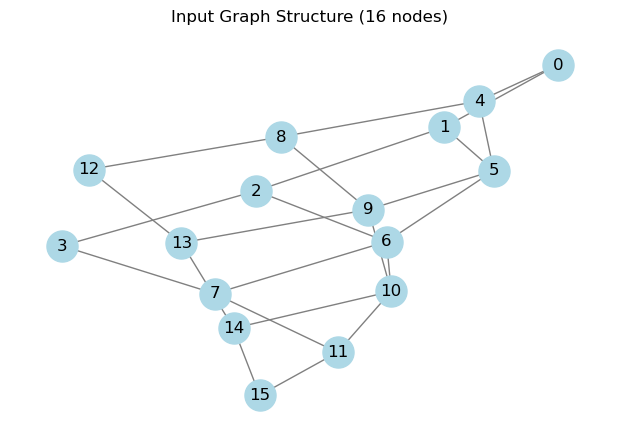

In [5]:
# Configuration
N_NODES = 16  # Small number for visualization
DIM = 8       # Embedding dimension

# 1. Create a Grid Graph
G = nx.grid_2d_graph(int(np.sqrt(N_NODES)), int(np.sqrt(N_NODES)))
# Relabel nodes to integers 0..N-1
G = nx.relabel_nodes(G, {node: i for i, node in enumerate(G.nodes())})

# 2. Compute Weighted Adjacency Matrix (Normalized)
A = nx.adjacency_matrix(G).todense().astype(float)
degrees = np.array(A.sum(axis=1)).flatten()
D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees + 1e-8)) # Add epsilon for stability
W = D_inv_sqrt @ A @ D_inv_sqrt  # Normalized Adjacency

# 3. Generate Dummy Features (Q, K, V)
# We make Q and K random, meaning "semantic" attention is random
Q = np.random.randn(N_NODES, DIM)
K = np.random.randn(N_NODES, DIM)
V = np.random.randn(N_NODES, DIM)

# Visualization
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title(f"Input Graph Structure ({N_NODES} nodes)")
plt.show()

## 2. The Problem: Vanilla Attention
Standard attention computes a dot product between every pair of nodes.
$$\text{Att} = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right)V$$

**Critique:** It is unaware of the graph topology. Node 0 might attend to Node 15 just as strongly as Node 1, simply because their random features happen to align.

<Figure size 600x500 with 0 Axes>

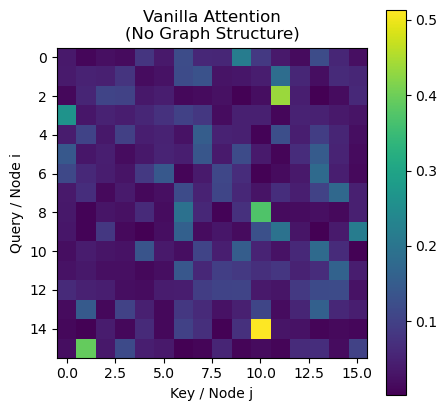

In [ ]:
def vanilla_attention(Q, K, V):
    d_k = Q.shape[-1]
    # Compute scores between ALL pairs (O(N^2))
    scores = Q @ K.T / np.sqrt(d_k)
    # Softmax
    attn_probs = np.exp(scores) / np.exp(scores).sum(axis=1, keepdims=True)
    return attn_probs @ V, attn_probs

output_vanilla, attn_vanilla = vanilla_attention(Q, K, V)

# Visualize
plt.figure(figsize=(6,5))
# MODIFICA QUI: Catturiamo l'oggetto 'im' restituito dalla funzione
im = visualize_matrix(attn_vanilla, "Vanilla Attention\n(No Graph Structure)")
# E lo passiamo esplicitamente a colorbar
plt.colorbar(im)
plt.show()a

## 3. The "Ideal" (but slow) Solution: Topological Masking
We want to inject a bias so nodes attend to their neighbors. We define a mask matrix $M(\mathcal{G})$ based on the adjacency matrix $W$.

A common kernel is a power series:
$$M_{\alpha}(\mathcal{G}) := \sum_{k=0}^{\infty} \alpha_{k}W^{k}$$

If $\alpha_1$ is high, we look at 1-hop neighbors. If $\alpha_2$ is high, we look at 2-hop neighbors.
We inject this into attention via Hadamard product ($\odot$):
$$\text{Att}_{\text{masked}} \propto (\exp(QK^T) \odot M) V$$

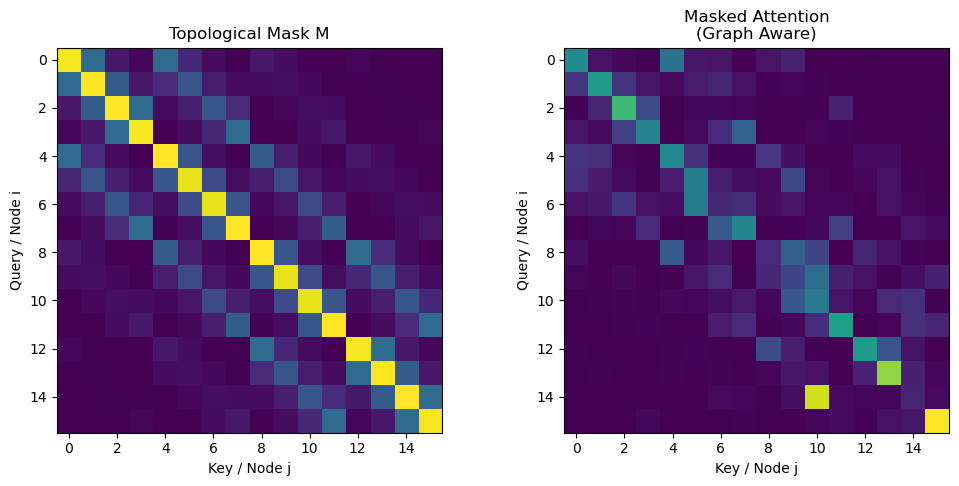

In [7]:
def compute_dense_mask(W, coeffs=[1.0, 0.8, 0.6, 0.4]):
    """Computes M = sum(alpha_k * W^k)"""
    N = W.shape[0]
    M = np.zeros((N, N))
    W_pow = np.eye(N)
    
    for alpha in coeffs:
        M += alpha * W_pow
        W_pow = W_pow @ W # Next power
    return M

# Create the Target Mask
M_dense = compute_dense_mask(W)

def masked_softmax_attention(Q, K, V, Mask):
    d_k = Q.shape[-1]
    scores = np.exp(Q @ K.T / np.sqrt(d_k))
    
    # INJECT TOPOLOGY HERE
    scores_masked = scores * Mask 
    
    # Normalize
    attn_probs = scores_masked / (scores_masked.sum(axis=1, keepdims=True) + 1e-8)
    return attn_probs @ V, attn_probs

output_masked, attn_masked = masked_softmax_attention(Q, K, V, M_dense)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
visualize_matrix(M_dense, "Topological Mask M", ax=ax[0])
visualize_matrix(attn_masked, "Masked Attention\n(Graph Aware)", ax=ax[1])
plt.show()

## 4. The Conflict: Why can't we just make it linear?

**Linear Attention** creates speed by using the associative property:
$$\text{LinearAtt} = \phi(Q) (\phi(K)^T V)$$
This is $O(N)$ because we never compute the $N \times N$ matrix.

**The Problem:** We want to multiply the $N \times N$ matrix by our Mask $M$.
$$(A \times B) \odot M \neq A \times (B \odot M)$$
We cannot insert the mask without breaking the linear decomposition. We are stuck between being **Graph-Aware (Slow)** or **Fast (Graph-Ignorant)**.

## 5. The Paper's Solution: Graph Random Features (GRF)

The authors propose a "Dot Product of Outer Products" trick.
If we can decompose the Mask $M$ into features $\phi_G$ such that $M_{ij} \approx \phi_G(i)^T \phi_G(j)$, we can merge the graph topology into the query/key features.

**The New Formula:**
$$\Phi_{\text{new}}(i) = \text{vec}(\phi(q_i) \otimes \phi_{\mathcal{G}}(v_i))$$

This creates a "super-feature" containing both content ($Q$) and topology ($G$).
We calculate $\phi_{\mathcal{G}}$ using **Random Walks**.

* **Concept:** We simulate random walkers starting at node $i$.
* **Interpretation:** $\phi_{\mathcal{G}}(i)$ is a sparse vector representing where a walker starting at $i$ tends to go.
* **Dot Product:** $\phi_{\mathcal{G}}(i)^T \phi_{\mathcal{G}}(j)$ is the probability that walkers from $i$ and $j$ "collide" (visit the same nodes).

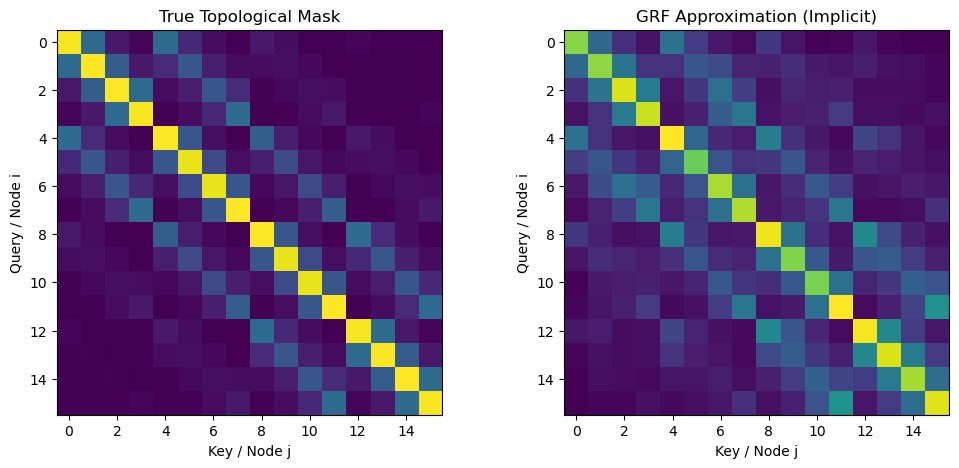

In [8]:
def sample_random_walks(G, n_walks=20, p_halt=0.3):
    """
    1. Start at every node.
    2. Walk randomly.
    3. Stop with probability p_halt.
    """
    walks = {}
    nodes = list(G.nodes())
    
    for start_node in nodes:
        current_node_walks = []
        for _ in range(n_walks):
            walk = [start_node]
            curr = start_node
            while True:
                if np.random.random() < p_halt: break # Halt
                neighbors = list(G.neighbors(curr))
                if not neighbors: break
                curr = np.random.choice(neighbors) # Step
                walk.append(curr)
            current_node_walks.append(walk)
        walks[start_node] = current_node_walks
    return walks

def compute_grf_features(walks, N_nodes, decay_coeffs=[1.0, 0.8, 0.6, 0.4]):
    """
    Convert walks into sparse feature vectors.
    Phi_G[i, j] tells us: "How often did a walk from i visit j?"
    """
    # Initialize sparse features (N x N)
    # In reality, this is sparse, but for visualization we make it dense
    GRFs = np.zeros((N_nodes, N_nodes)) 
    
    for i, node_walks in walks.items():
        n_walks = len(node_walks)
        for walk in node_walks:
            for step, visited_node in enumerate(walk):
                # Weight decays with distance (step)
                weight = decay_coeffs[min(step, len(decay_coeffs)-1)]
                GRFs[i, visited_node] += weight
        
        GRFs[i] /= n_walks # Normalize
        
    return GRFs

# 1. Sample Walks
walks = sample_random_walks(G, n_walks=50, p_halt=0.3)

# 2. Build Features
Phi_G = compute_grf_features(walks, N_NODES)

# 3. Check approximation
# Does Phi_G * Phi_G.T approximate the Dense Mask?
M_approx = Phi_G @ Phi_G.T

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
visualize_matrix(M_dense, "True Topological Mask", ax=ax[0])
visualize_matrix(M_approx, "GRF Approximation (Implicit)", ax=ax[1])
plt.show()

## 6. The Merger: Linear Attention + GRF

Now we combine them. Instead of explicitly building the attention matrix, we modify the features $Q$ and $K$ using the Graph Features $\phi_G$.

*Note: In the actual $O(N)$ implementation, we use sparse operations. For this visual tutorial, we calculate the resulting effective attention matrix to prove it matches the expensive one.*

$$\text{Att}_{\text{GRF}} = (\Phi_Q \Phi_K^T \odot (\Phi_G \Phi_G^T)) V$$
Which, thanks to the trick, allows us to use the linear attention order of operations.

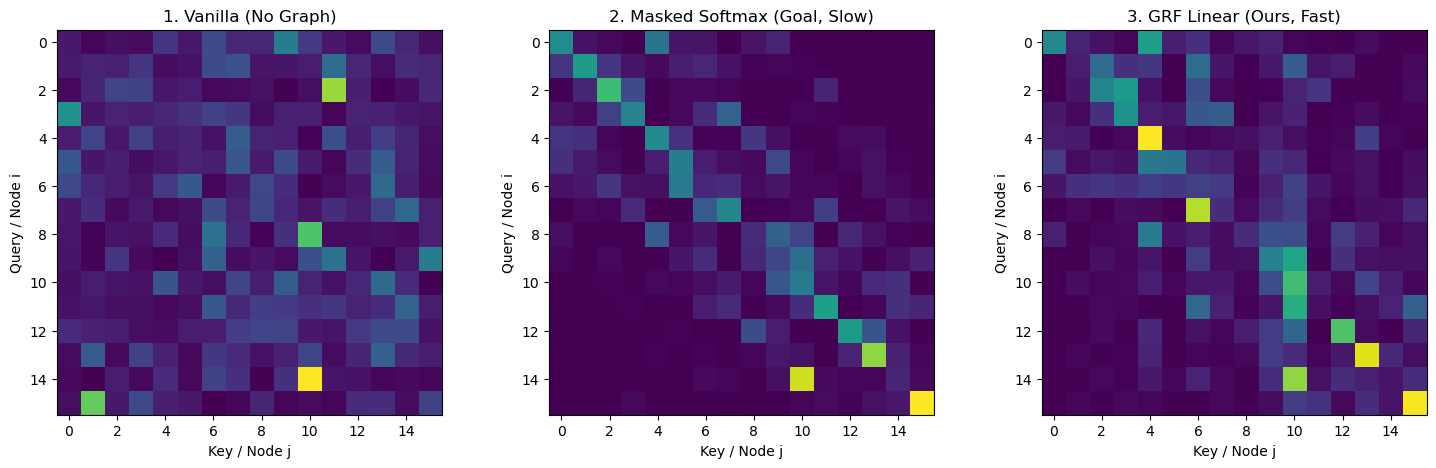

In [9]:
def grf_linear_attention_simulation(Q, K, V, GRFs):
    """
    Simulates the math of the paper.
    We modulate the QK interaction by the GRF interaction.
    """
    # Standard Linear Features (e.g. ReLU)
    phi_Q = np.maximum(0, Q)
    phi_K = np.maximum(0, K)
    
    # The "Implicit" Attention Matrix created by the paper's method
    # Score_ij = (phi_Q_i * phi_K_j) * (phi_G_i * phi_G_j)
    
    semantic_scores = phi_Q @ phi_K.T
    graph_scores = GRFs @ GRFs.T
    
    # Element-wise mix (The Topological Masking)
    combined_scores = semantic_scores * graph_scores
    
    # Normalize
    D = combined_scores.sum(axis=1, keepdims=True)
    attn_weights = combined_scores / (D + 1e-8)
    
    return attn_weights @ V, attn_weights

output_grf, attn_grf = grf_linear_attention_simulation(Q, K, V, Phi_G)

# Final Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
visualize_matrix(attn_vanilla, "1. Vanilla (No Graph)", ax=axes[0])
visualize_matrix(attn_masked, "2. Masked Softmax (Goal, Slow)", ax=axes[1])
visualize_matrix(attn_grf, "3. GRF Linear (Ours, Fast)", ax=axes[2])
plt.show()

In [10]:
# Numerical check of Node 0's output
print("Output vector for Node 0 comparison:")
print(f"Vanilla: {output_vanilla[0][:4]}")
print(f"Masked:  {output_masked[0][:4]}")
print(f"GRF:     {output_grf[0][:4]}")

# Error calculation
error = np.linalg.norm(output_masked - output_grf)
print(f"\nDifference between Expensive Masked and Fast GRF: {error:.4f}")

Output vector for Node 0 comparison:
Vanilla: [ 0.3300225   0.29101918  0.25489855 -0.2201835 ]
Masked:  [ 0.70917347 -0.43667888  0.22885225  0.1212376 ]
GRF:     [ 0.56663819 -0.36713223  0.26453785 -0.03094362]

Difference between Expensive Masked and Fast GRF: 2.8482


### Conclusion

1.  **Vanilla Attention** smears attention everywhere (Matrix 1).
2.  **Masked Softmax** correctly focuses on the diagonal (neighbors), but costs $O(N^2)$ (Matrix 2).
3.  **GRF Linear Attention** successfully reconstructs the diagonal structure using random walks (Matrix 3).

**Why is this a breakthrough?**
Because Matrix 3 is calculated **without ever building the $N \times N$ matrix**.
We simply carry around sparse vectors $\phi_G$ (size $N$, but mostly zeros) attached to our tokens.
This allows transformers to run on graphs with 30k+ nodes (like Protein folding or Robotics point clouds) where $O(N^2)$ would crash the memory.